In [4]:
# NOTE TO USERS:
# This py notebook uses CUDA Compat to accelerate processing times.
# You should be using torch 2.3.0, and CUDA 11.2, though CUDA is not necessary, and can be run from your computers CPU.
print(torch.__version__)

2.3.0


In [3]:
# Imports Cell, please leave all imports here for clarity.
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rcParams

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR

from torchvision import transforms, datasets
from torchvision.transforms import v2

import torchvision.models as models
from torchvision.models.resnet import ResNet34_Weights

from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Global overwrite for font styling on graphic data.
rcParams['font.family'] = "Consolas"

In [4]:
# Checking for GPU Acceleration capabilities. (Will switch to CPU if not available.)
print(torch.__version__)

if torch.cuda.is_available():
    print("CUDA is available.")
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")
    
print("Number of CUDA devices: ", torch.cuda.device_count())

2.3.0
CUDA is available.
NVIDIA GeForce RTX 3080
Number of CUDA devices:  1


In [5]:
# Training Set Image Preprocessing Steps:

train_transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0.1, hue=0.1),
    transforms.CenterCrop(200), 
    transforms.Resize(80),  
    transforms.RandomInvert(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Training + Validation Dataset Directory Path
dataset = datasets.ImageFolder('C:/Users/jrgg1/OneDrive/Desktop/gdv_dataset', transform=train_transform)

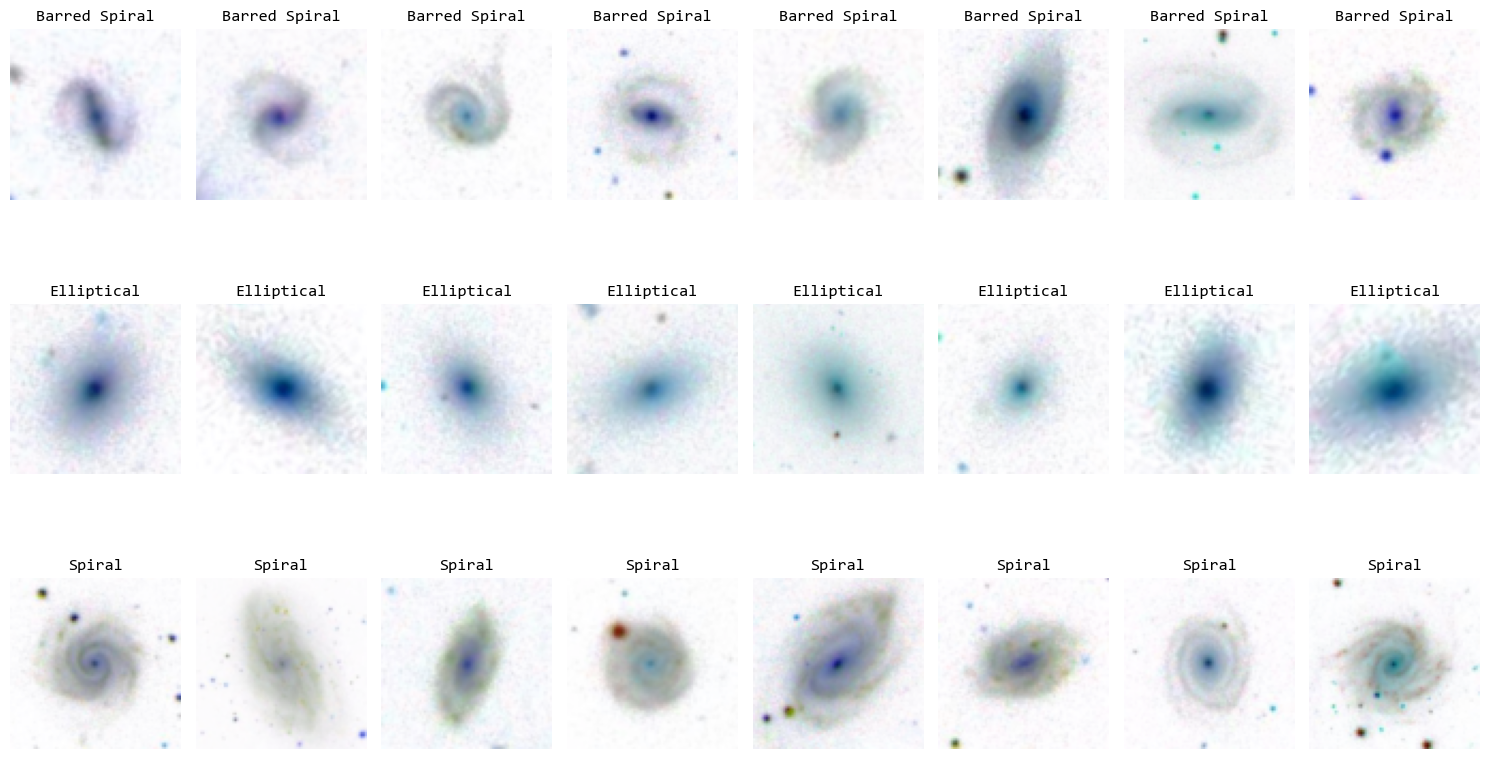

In [7]:
# Show examples of all image categories:
def imshow_transformed(tensor, title, ax):
    # Reverse normalization for display
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    tensor = tensor * std[:, None, None] + mean[:, None, None]  # Unnormalize
    tensor = tensor.numpy().transpose((1, 2, 0))  # Convert from tensor format to image format
    ax.imshow(tensor)
    ax.set_title(title)
    ax.axis('off')  # Turn off axis

# Create a dictionary to track how many examples of each class have been found.
images_per_class = 8
found_images = {class_name: 0 for class_name in dataset.classes}

fig, axes = plt.subplots(len(dataset.classes), images_per_class, figsize=(15, 3 * len(dataset.classes)))

# Iterate through the dataset.
for image, label in dataset:
    class_name = dataset.classes[label]
    if found_images[class_name] < images_per_class:
        ax = axes[label][found_images[class_name]]
        imshow_transformed(image, class_name, ax)
        found_images[class_name] += 1
        # Check if all classes have enough examples. (They do)
        if all(count == images_per_class for count in found_images.values()):
            break

plt.tight_layout()
plt.show()

In [8]:
# Training Set Splitting.
train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

In [11]:
# Model Initialization.
model = models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

num_classes = 3  # Adjust this based on the number of galaxy categories
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [21]:
num_epochs = 20
best_accuracy = 0.0  # Initialize the best accuracy for model checkpointing
train_losses = []  # To store training loss per epoch
validation_accuracies = []  # To store validation accuracy per epoch

# Assume optimizer is already defined
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Decreases the learning rate every 5 epochs by a factor of 0.1

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate average loss and store it
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Learning rate scheduling
    scheduler.step()  # Adjust the learning rate based on the step scheduler

    # Print training loss every epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validate after each epoch
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        validation_accuracies.append(validation_accuracy)
        print(f'Validation Accuracy: {validation_accuracy}%')

        # Model checkpointing based on validation accuracy
        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Saved improved model with Validation Accuracy: {validation_accuracy}% at Epoch {epoch+1}")

Epoch 1, Loss: 0.09540203936034586
Validation Accuracy: 97.85276073619632%
Saved improved model with Validation Accuracy: 97.85276073619632% at Epoch 1
Epoch 2, Loss: 0.08704743593386034
Validation Accuracy: 98.15950920245399%
Saved improved model with Validation Accuracy: 98.15950920245399% at Epoch 2
Epoch 3, Loss: 0.09147315967555453
Validation Accuracy: 97.23926380368098%
Epoch 4, Loss: 0.08793117996396088
Validation Accuracy: 98.15950920245399%
Epoch 5, Loss: 0.09513878935902584
Validation Accuracy: 98.15950920245399%
Epoch 6, Loss: 0.0930775285630328
Validation Accuracy: 97.85276073619632%
Epoch 7, Loss: 0.10510761579271496
Validation Accuracy: 97.85276073619632%
Epoch 8, Loss: 0.08943797811502363
Validation Accuracy: 97.54601226993866%
Epoch 9, Loss: 0.10460890497921443
Validation Accuracy: 97.23926380368098%
Epoch 10, Loss: 0.08661088579129882
Validation Accuracy: 98.15950920245399%


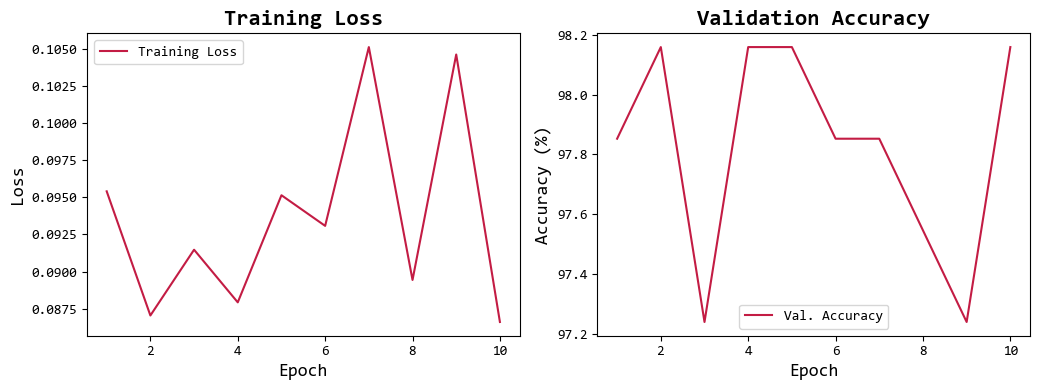

In [22]:
# Plotting graphs for training loss and validation accuracy.
plt.figure(figsize=(10.5, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='#c31c44')
plt.title('Training Loss', fontweight="semibold", fontsize=16)
plt.xlabel('Epoch', fontweight="medium", fontsize=13)
plt.ylabel('Loss', fontweight="medium", fontsize=13)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), validation_accuracies, label='Val. Accuracy', color='#c31c44')
plt.title('Validation Accuracy', fontweight="semibold", fontsize=16)
plt.xlabel('Epoch', fontweight="medium", fontsize=13)
plt.ylabel('Accuracy (%)', fontweight="medium", fontsize=13)
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Testing Set Image Preprocessing Steps:

test_transform = transforms.Compose([
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.30, saturation=0.0, hue=0.1),
    transforms.CenterCrop(224), 
    transforms.Resize(80),  
    transforms.RandomInvert(1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
# Testing Set Loading and Model Setting

test_dataset = datasets.ImageFolder('C:/Users/jrgg1/OneDrive/Desktop/gdv_dataset_test', transform=train_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

model.eval()
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
best_accuracy = 0  # Variable to store the best accuracy
best_confusion_matrix = None # Best runs conf. matrix
best_report = None # Best runs stat report.

for i in range(20): # Change range for number of runs.
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Run {i + 1}: Accuracy on test set: {accuracy:.2f}%')

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_confusion_matrix = confusion_matrix(all_labels, all_preds)
        best_report = classification_report(all_labels, all_preds, target_names=test_dataset.classes)

# Print data
print(f"Best accuracy achieved: {best_accuracy:.2f}%")
print("Best Confusion Matrix:")
print(best_confusion_matrix)
print("Best Classification Report:")
print(best_report)

Run 1: Accuracy on test set: 96.04%
Run 2: Accuracy on test set: 96.04%
Run 3: Accuracy on test set: 96.53%
Run 4: Accuracy on test set: 96.04%
Run 5: Accuracy on test set: 96.53%
Run 6: Accuracy on test set: 96.04%
Run 7: Accuracy on test set: 96.53%
Run 8: Accuracy on test set: 96.53%
Run 9: Accuracy on test set: 95.79%
Run 10: Accuracy on test set: 97.28%
Run 11: Accuracy on test set: 98.02%
Run 12: Accuracy on test set: 96.53%
Run 13: Accuracy on test set: 97.52%
Run 14: Accuracy on test set: 96.04%
Run 15: Accuracy on test set: 96.29%
Run 16: Accuracy on test set: 96.78%
Run 17: Accuracy on test set: 97.52%
Run 18: Accuracy on test set: 97.52%
Run 19: Accuracy on test set: 95.79%
Run 20: Accuracy on test set: 95.54%
Best accuracy achieved: 98.02%
Best Confusion Matrix:
[[130   0   5]
 [  0 135   0]
 [  2   1 131]]
Best Classification Report:
               precision    recall  f1-score   support

Barred Spiral       0.98      0.96      0.97       135
   Elliptical       0.99      

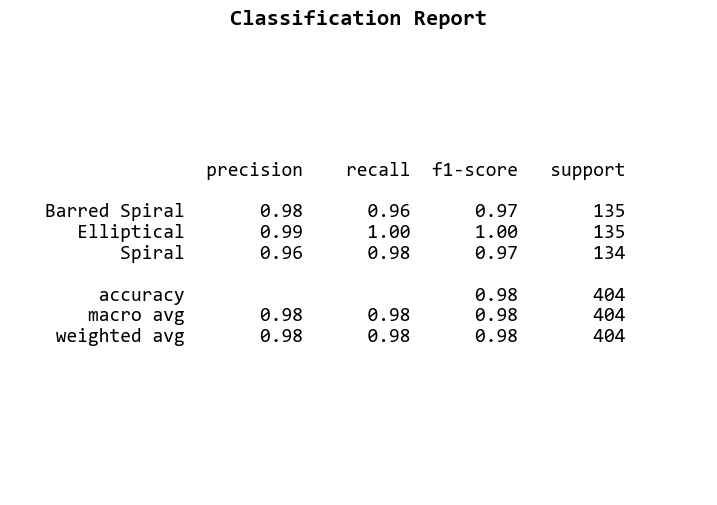

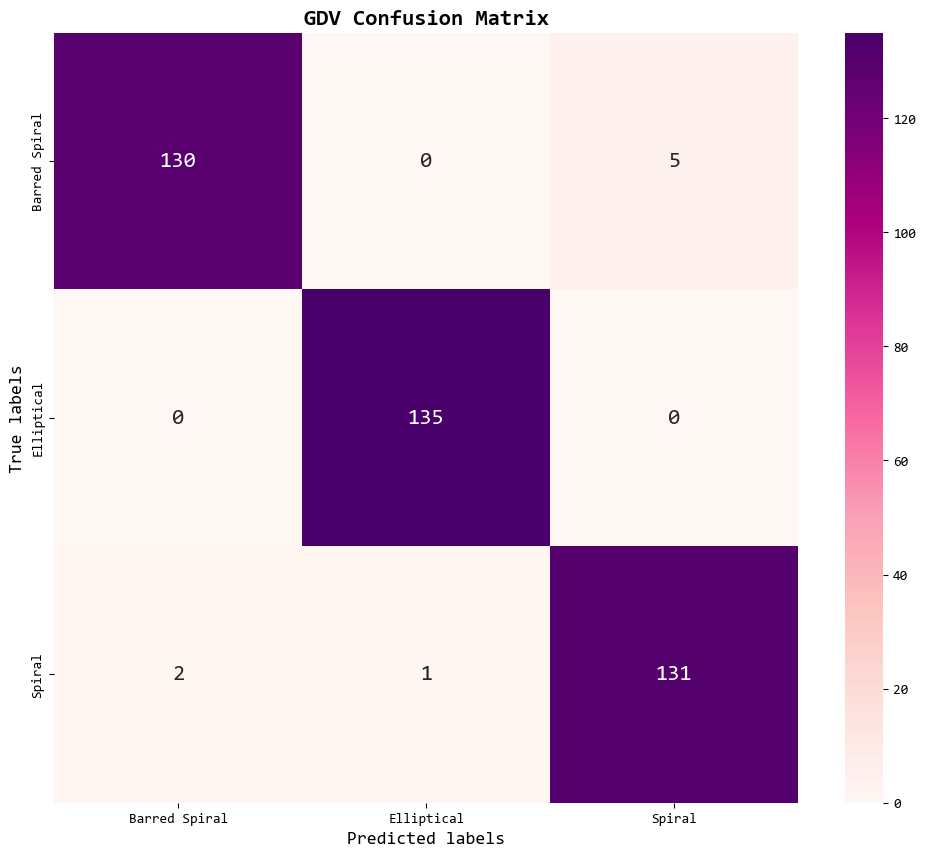

In [26]:
# Plot classification report as a table.
plt.figure(figsize=(9, 6))
plt.text(0.05, 0.5, best_report, fontsize=14, verticalalignment='center', horizontalalignment='left',bbox=dict(facecolor='lightblue', alpha=0.0, boxstyle='square'))
plt.title('Classification Report', fontsize=16, fontweight="semibold")

plt.axis('off')
plt.show()
# Plot the confusion matrix as a heatmap.
plt.figure(figsize=(12, 10))
sns.heatmap(best_confusion_matrix, annot=True, annot_kws={"size": 16}, fmt='d', cmap='RdPu', 
            xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted labels', fontweight="medium", fontsize=13)
plt.ylabel('True labels', fontweight="medium", fontsize=13)
plt.title('GDV Confusion Matrix', fontweight="semibold", fontsize=16)

plt.show()

In [ ]:
# END